Just-in-time compilation (JIT)
====

For programmer productivity, it often makes sense to code the majority of your application in a high-level language such as Python and only optimize code bottlenecks identified by profiling. One way to speed up these bottlenecks is to compile the code to machine executables, often via an intermediate C or C-like stage. There are two common approaches to compiling Python code - using a Just-In-Time (JIT) compiler and using Cython for Ahead of Time (AOT) compilation.

This notebook mostly illustrates the JIT approach.

**References**

- [Numba](http://numba.pydata.org)
- [The need for speed without bothering too much: An introduction to numba](http://nbviewer.jupyter.org/github/akittas/presentations/blob/master/pythess/numba/numba.ipynb?utm_source=newsletter_mailer&utm_medium=email&utm_campaign=weekly)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

**Utility function for timing functions**

In [2]:
import time
from numpy.testing import assert_almost_equal

In [3]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start

In [4]:
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

Using `numexpr`
----

One of the simplest approaches is to use [`numexpr`](https://github.com/pydata/numexpr) which takes a `numpy` expression and compiles a more efficient version of the `numpy` expression written as a string. If there is a simple expression that is taking too long, this is a good choice due to its simplicity. However, it is quite limited.

In [5]:
import numpy as np
a = np.random.random(int(1e6))
b = np.random.random(int(1e6))
c = np.random.random(int(1e6))

In [6]:
%timeit -r3 -n3 b**2 - 4*a*c

9.44 ms ± 1.36 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [7]:
import numexpr as ne

In [8]:
%timeit -r3 -n3 ne.evaluate('b**2 - 4*a*c')

2.52 ms ± 779 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


Using `numba`
----

When it works, the JIT `numba` can speed up Python code tremendously with minimal effort. 

[Documentation for `numba`](http://numba.pydata.org/numba-doc/0.12.2/index.html)

### Example 1

#### Plain Python version

In [9]:
def matrix_multiply(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k, j]
    return C

In [10]:
A = np.random.random((30, 50))
B = np.random.random((50, 40))

#### Numba jit version

In [11]:
import numba
from numba import jit

In [12]:
@jit
def matrix_multiply_numba(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k, j]
    return C

In [13]:
%timeit matrix_multiply(A, B)
%timeit matrix_multiply_numba(A, B)

43.1 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59 µs ± 3.57 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Numpy version

In [14]:
def matrix_multiply_numpy(A, B):
    return A.dot(B)

#### Check that outputs are the same

In [15]:
assert_almost_equal(matrix_multiply(A, B), matrix_multiply_numba(A, B))
assert_almost_equal(matrix_multiply(A, B), matrix_multiply_numpy(A, B))

In [16]:
%timeit -r3 -n3 matrix_multiply_numba(A, B)

60.6 µs ± 1.85 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [17]:
report([matrix_multiply, matrix_multiply_numba, matrix_multiply_numpy], A, B)

matrix_multiply: 1.0
matrix_multiply_numba: 591.2
matrix_multiply_numpy: 550.0


### Pre-compilation by giving specific signature 

In [18]:
@jit('double[:,:](double[:,:], double[:,:])')
def matrix_multiply_numba_1(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k, j]
    return C

In [19]:
%timeit matrix_multiply_numba(A, B)
%timeit matrix_multiply_numba_1(A, B)

57.4 µs ± 303 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
53.7 µs ± 263 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Example 2: Using nopython

#### Vectorized Python version

In [20]:
def mc_pi(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

In [21]:
n = int(1e6)

In [22]:
%timeit mc_pi(n)

57.4 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Numba on vectorized version

In [23]:
@jit
def mc_pi_numba(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

In [24]:
%timeit mc_pi_numba(n)

38.2 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Using nopython

In [25]:
@jit(nopython=True)
def mc_pi_numba_njit(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

In [26]:
from numba.errors import TypingError

In [27]:
try:
    mc_pi_numba_njit(n)
except TypingError:
    print("Unable to convert to pure C code.")

#### Numba on unrolled version

In [28]:
@jit(nopython=True)
def mc_pi_numba_unrolled(n):
    s = 0
    for i in range(n):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if (x*x + y*y) < 1:
            s += 1
    return 4*s/n

In [29]:
%timeit mc_pi_numba_unrolled(n)

21.9 ms ± 54.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Usig cache=True

This stores the compiled function in a file and avoids re-compilation on re-running a Python program.

In [30]:
@jit(nopython=True, cache=True)
def mc_pi_numba_unrolled_cache(n):
    s = 0
    for i in range(n):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if (x*x + y*y) < 1:
            s += 1
    return 4*s/n

In [31]:
%timeit mc_pi_numba_unrolled_cache(n)

21.9 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Using numba vectorize and guvectoize
----

Sometimes it is convenient to use `numba` to convert functions to vectorized functions for use in `numpy`. See [documentation](http://numba.pydata.org/numba-doc/dev/user/vectorize.html) for details.

In [32]:
from numba import int32, int64, float32, float64

### Using `vectorize`

In [33]:
@numba.vectorize()
def f(x, y):
    return np.sqrt(x**2 + y**2)

In [34]:
xs = np.random.random(10)
ys = np.random.random(10)

In [35]:
np.array([np.sqrt(x**2 + y**2) for (x, y) in zip(xs, ys)])

array([0.52017797, 0.60036725, 0.98036295, 0.73798956, 1.23158168,
       0.75068551, 0.79861068, 0.80421275, 1.25123047, 0.50919095])

In [36]:
f(xs, ys)

array([0.52017797, 0.60036725, 0.98036295, 0.73798956, 1.23158168,
       0.75068551, 0.79861068, 0.80421275, 1.25123047, 0.50919095])

### Adding function signatures

In [37]:
@numba.vectorize([float64(float64, float64),
                  float32(float32, float32),
                  float64(int64, int64),
                  float32(int32, int32)])
def f_sig(x, y):
    return np.sqrt(x**2 + y**2)

In [38]:
f_sig(xs, ys)

array([0.52017797, 0.60036725, 0.98036295, 0.73798956, 1.23158168,
       0.75068551, 0.79861068, 0.80421275, 1.25123047, 0.50919095])

### Using `guvectorize` 

**Create our own version of inner1d**

In [39]:
@numba.guvectorize([(float64[:], float64[:], float64[:])], '(n),(n)->()')
def nb_inner1d(u, v, res):
    res[0] = 0
    for i in range(len(u)):
        res[0] += u[i]*v[i]

In [40]:
xs = np.random.random((3,4))

In [41]:
nb_inner1d(xs, xs)

array([1.68593054, 1.91540631, 2.1076339 ])

**Check**

In [42]:
from numpy.core.umath_tests import inner1d

In [43]:
inner1d(xs,xs)

array([1.68593054, 1.91540631, 2.1076339 ])

In [44]:
%timeit -r3 -n3 nb_inner1d(xs, xs)

The slowest run took 4.94 times longer than the fastest. This could mean that an intermediate result is being cached.
4.86 µs ± 3.82 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [45]:
%timeit -r3 -n3 inner1d(xs, xs)

The slowest run took 4.83 times longer than the fastest. This could mean that an intermediate result is being cached.
4.95 µs ± 3.85 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


**Create our own version of matrix_multiply**

In [46]:
@numba.guvectorize([(int64[:,:], int64[:,:], int64[:,:])], 
                    '(m,n),(n,p)->(m,p)')
def nb_matrix_multiply(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]

In [47]:
xs = np.random.randint(0, 10, (5, 2, 3))
ys = np.random.randint(0, 10, (5, 3, 2))

In [48]:
nb_matrix_multiply(xs, ys)

array([[[ 47,  42],
        [ 87,  60]],

       [[ 49,  54],
        [ 35, 101]],

       [[ 58,  70],
        [ 24,  45]],

       [[117,  96],
        [ 85,  70]],

       [[ 79,  81],
        [ 86,  90]]])

**Check**

In [49]:
from numpy.core.umath_tests import matrix_multiply

In [50]:
matrix_multiply(xs, ys)

array([[[ 47,  42],
        [ 87,  60]],

       [[ 49,  54],
        [ 35, 101]],

       [[ 58,  70],
        [ 24,  45]],

       [[117,  96],
        [ 85,  70]],

       [[ 79,  81],
        [ 86,  90]]])

In [51]:
%timeit -r3 -n3 nb_matrix_multiply(xs, ys)

The slowest run took 6.21 times longer than the fastest. This could mean that an intermediate result is being cached.
6.95 µs ± 6.14 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [52]:
%timeit -r3 -n3 matrix_multiply(xs, ys)

The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
5.69 µs ± 4.22 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


Parallelization with vectorize and guvectorize
----

In [53]:
@numba.vectorize([float64(float64, float64),
                  float32(float32, float32),
                  float64(int64, int64),
                  float32(int32, int32)],
                 target='parallel')
def f_parallel(x, y):
    return np.sqrt(x**2 + y**2)

In [54]:
xs = np.random.random(int(1e8))
ys = np.random.random(int(1e8))

In [55]:
%timeit f(xs, ys)

1.4 s ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%timeit f_parallel(xs, ys)

320 ms ± 6.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Mandelbrot example with `numba`

**Pure Python**

In [57]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [58]:
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color    

Mandelbrot created on CPU in 22.444073 s


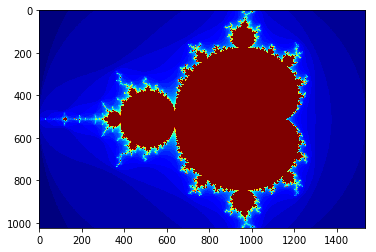

In [59]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass

**Numba**

In [60]:
from numba import uint32, float32

**The jit decorator can also be called as a regular function**

In [61]:
mandel_numba = jit(uint32(float32, float32, uint32))(mandel)

In [62]:
@jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color  

Mandelbrot created wiht Numba in 0.249863 s


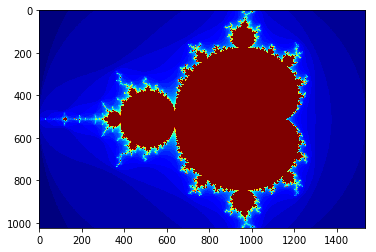

In [63]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created wiht Numba in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass